<center><h1>Predictive Analytics (QBUS2820)</h1></center>
<center><h2>Tutorial 7 (Variable Selection and Regularisation Methods)</h2></center>
<br>

In this tutorial we will study how to implement the variable selection, regularisation methods for linear regression in Python. 

This module requires the <TT>QBUS2820.py</TT> module. Interested students can refer to that code for the details.

<a class="buttom" href="#Data">Data</a> <br>
<a class="buttom" href="#Exploratory-data-analysis">Exploratory data analysis</a> <br>
<a class="buttom" href="#Standardising-the-predictors">Standardising the predictors</a> <br>
<a class="buttom" href="#OLS">OLS</a> <br>
<a class="buttom" href="#Variable-selection">Variable selection</a> <br>
<a class="buttom" href="#Regularisation-methods">Regularisation methods</a> <br>
<a class="buttom" href="#Cross-validation-results">Cross validation results</a> <br>
<a class="buttom" href="#Test-results">Test results</a> <br>


This notebook relies on the following imports and settings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_context('notebook') 
sns.set_style('ticks')

### Data

Our analysis will be based on a customer acquisition and profitability dataset.  

In [2]:
data = pd.read_excel('CustomerAcquisition.xls', index_col=[0])
data.head()

,Acquisition,First_Purchase,CLV,Duration,Censor,Acq_Expense,Acq_Expense_SQ,Industry,Revenue,Employees,Ret_Expense,Ret_Expense_SQ,Crossbuy,Frequency,Frequency_SQ
Customer,,,,,,,,,,,,,,,
1,1,433.64,0.0000,384,0,760.36,578147.33,1,30.16,1240,2309.79,5335129.84,5,2,4
2,0,0.00,0.0000,0,0,147.70,21815.29,1,39.80,166,0.00,0.00,0,0,0
3,0,0.00,0.0000,0,0,252.56,63786.55,1,54.93,1016,0.00,0.00,0,0,0
4,1,225.84,5.7316,730,1,609.73,371770.67,1,45.83,122,2192.59,4807450.91,2,12,144
5,1,363.04,0.0000,579,0,672.36,452067.97,1,69.03,313,801.14,641825.30,4,7,49


The objective of this type of analysis is to predict the profitability of a customer, which involves both classification and regression tasks. We apply classification methods to predict whether a customer will be acquired and retained, and regression methods to estimate the of acquired and retained customers to the company.  Here, we focus on this regression task, though a more complete model can include all parts of the customer cycle. 

The response variable for this tutorial is the customer lifetime value (CLV, a measure of profitability) of customers who were acquired and remained as customers by the end of the observation window (730 days). These customers are identified with a value of one for the <TT>Censor</TT> variable.

In [3]:
data = data[data['Censor']==1]

The predictors are the value of the first purchase, dollars spent on marketing expenses for acquiring and retaining the customer, industry, revenue and number of employees of the customer, the number of product categories the customer purchased, and the number of times the customer purchased during the observation window.

It is important to recognise that linear model selection and regularisation methods only tend to lead to substantial improvements in performance over OLS in relatively complex settings (or with small sample sizes). For example, if you try Exercises 8 and 9 in Chapter 6 of ISL (the main data problems from the chapter), you will find no predictive gain from using the methods from the same part of the book, which can be disappointing.  

Here, for illustrative purposes, we engineer a situation in which OLS will potentially overfit by adding several plausible interaction and polynomial terms to the analysis. However, keep in mind that in practical settings you should not add regressors to a model indiscriminately, and rely instead on EDA and model building to avoid overfitting. All methods are subject to deterioration in performance from irrelevant predictors. 

In [4]:
data=pd.get_dummies(data, columns=['Crossbuy'], drop_first=True)
data['I1'] = data['First_Purchase']*data['Industry']
data['I2'] = data['Acq_Expense']*data['Industry']
data['I3'] = data['Acq_Expense_SQ']*data['Industry']
data['I4'] = data['Employees']*data['Industry']
data['I5'] = data['Ret_Expense']*data['Industry']
data['I6'] = data['Ret_Expense_SQ']*data['Industry']
data['I7'] = data['Revenue']*data['Industry']
data['I8'] = data['Frequency']*data['Industry']
data['First_Purchase_SQ']=data['First_Purchase']**2
data['First_Purchase_3']=data['First_Purchase']**3
data['Employees_SQ']=data['Employees']**2
data['Employees_3']=data['Employees']**3
data['Ret_Expense_3']=data['Ret_Expense']**3

Below, we record the name of the response and predictor variables for subsequent use. This is efficient since most of the code is completely automated from here onwards, allowing us to fastly implement the same type of analysis for different data. 

In [5]:
response = ['CLV']
exclude = response + ['Acquisition', 'Duration', 'Censor'] # list of variables who are NOT predictors
predictors=[x for x in list(data.columns) if x not in exclude] # building a list a predictors
data=data[response+predictors] # excluding variabes which we are not going to use
data.head()

,CLV,First_Purchase,Acq_Expense,Acq_Expense_SQ,Industry,Revenue,Employees,Ret_Expense,Ret_Expense_SQ,Frequency,...,I4,I5,I6,I7,I8,First_Purchase_SQ,First_Purchase_3,Employees_SQ,Employees_3,Ret_Expense_3
Customer,,,,,,,,,,,,,,,,,,,,,
4,5.7316,225.84,609.73,371770.67,1,45.83,122,2192.59,4807450.91,12,...,122,2192.59,4807450.91,45.83,12,51003.7056,1.151868e+07,14884,1815848,1.054077e+10
9,6.9161,599.30,452.35,204620.52,1,17.98,1782,1340.75,1797610.56,11,...,1782,1340.75,1797610.56,17.98,11,359160.4900,2.152449e+08,3175524,5658783768,2.410146e+09
10,6.0839,271.18,786.72,618928.36,1,38.91,539,2265.93,5134438.76,14,...,539,2265.93,5134438.76,38.91,14,73538.5924,1.994220e+07,290521,156590819,1.163428e+10
14,8.7544,678.06,472.13,222906.74,0,58.91,1507,2430.31,5906406.70,2,...,0,0.00,0.00,0.00,0,459765.3636,3.117485e+08,2271049,3422470843,1.435440e+10
16,6.5147,178.28,610.91,373211.03,1,33.78,41,2071.53,4291236.54,8,...,41,2071.53,4291236.54,33.78,8,31783.7584,5.666408e+06,1681,68921,8.889425e+09


We are ready to split the data into training and test sets. 

In [6]:
train = data.sample(frac=0.5, random_state=1)
test = data[data.index.isin(train.index)==False].copy()

### Exploratory Data Analysis

It is helpful to gain some insight on the predictors by computing their correlations with the response. 

In [7]:
pd.set_option('display.max_columns', 30)
pd.DataFrame(train[response+predictors].corr().iloc[0,:]).sort_values(by='CLV', ascending=False).round(3).T

,CLV,Employees,First_Purchase,First_Purchase_SQ,Employees_SQ,First_Purchase_3,Employees_3,I4,I6,Ret_Expense,I1,I5,Ret_Expense_SQ,Ret_Expense_3,Crossbuy_6,I7,Revenue,I8,Industry,I2,Crossbuy_5,Crossbuy_4,I3,Frequency,Crossbuy_3,Frequency_SQ,Crossbuy_2,Acq_Expense_SQ,Acq_Expense
CLV,1.0,0.544,0.539,0.511,0.499,0.477,0.446,0.426,0.403,0.398,0.38,0.373,0.358,0.321,0.285,0.282,0.2,0.177,0.176,0.091,0.086,0.061,0.022,-0.025,-0.035,-0.058,-0.172,-0.297,-0.297


By plotting some of the predictors against the response, we find that there are potential nonlinearities in the data. Even though we use polynomials for simplicity, it seems that linear splines (from QBUS2810) would be more suitable here.

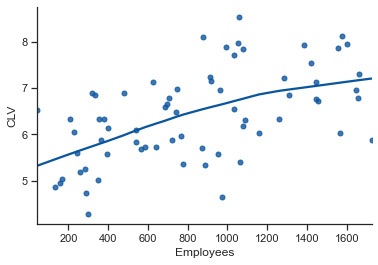

In [8]:
sns.regplot(train['Employees'], train['CLV'],  scatter_kws = {'s': 25}, lowess=True, color=sns.color_palette('Blues')[-1])
sns.despine()
plt.show()

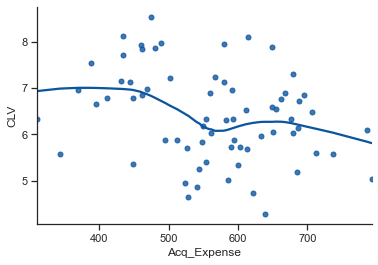

In [9]:
sns.regplot(train['Acq_Expense'], train['CLV'],  scatter_kws = {'s': 25}, lowess=True, color=sns.color_palette('Blues')[-1])
sns.despine()
plt.show()

### Standardising the predictors

The regularisation method require us to standardise the predictors by substracting the mean (0 mean) and dividing the standard deviation (unit standard deviation). We need to apply the same transformations to the predictors in the test data, where the mean and variance are based on the training data only.  

Alternatively, you can use the [standard scaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) from <TT>Scikit Learn</TT> for this task. 

Here we do not center the response variable, as later on **LassoCV, RidgeCV and ElasticNetCV** can calcualte the intercept term automatically (**fit_intercept=True** by default). As this, later on the model predictions will be on the original scale of the response variable.

In [10]:
mu=train[predictors].mean() # mean for each feature
sigma=train[predictors].std() # std for each feature

Mean for each feature

In [11]:
mu.head()

First_Purchase       424.133824
Acq_Expense          563.333824
Acq_Expense_SQ    328524.992647
Industry               0.705882
Revenue               40.867500
dtype: float64

Standard deviation for each feature

In [12]:
sigma.head()

First_Purchase       149.298535
Acq_Expense          106.521648
Acq_Expense_SQ    119095.465998
Industry               0.459033
Revenue               16.173683
dtype: float64

### Standardisation
**Note how we standardise the test predictors**

In [13]:
train[predictors]=(train[predictors]-mu)/sigma
test[predictors]=(test[predictors]-mu)/sigma

Train features means after standarisation

In [14]:
train[predictors].mean().head()

First_Purchase    9.959354e-17
Acq_Expense      -1.369819e-15
Acq_Expense_SQ   -2.693924e-16
Industry         -1.322472e-16
Revenue          -4.179663e-16
dtype: float64

Train features standard deviations after standarisation

In [15]:
train[predictors].std().head()

First_Purchase    1.0
Acq_Expense       1.0
Acq_Expense_SQ    1.0
Industry          1.0
Revenue           1.0
dtype: float64

Test features means after standarisation

In [16]:
test[predictors].mean().head()

First_Purchase    0.031816
Acq_Expense      -0.245505
Acq_Expense_SQ   -0.255916
Industry          0.022952
Revenue           0.162506
dtype: float64

Test feature standard deviations after standarisation

In [17]:
test[predictors].std().head()

First_Purchase    0.929608
Acq_Expense       0.921030
Acq_Expense_SQ    0.887199
Industry          0.989337
Revenue           1.062021
dtype: float64

### OLS
Note for OLS we do not have to standardise the predictors. Here we use the same features for all methods only for convenience.

In [18]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()
ols.fit(train[predictors], train[response])

LinearRegression()

### Variable selection

Even though <TT>Scikit Learn</TT> has some features for variable selection, they do not correspond the methods that we have seen in the lecture. Therefore, we write code for variable selection in the predictive analytics module. Our results will be based on forwad selection. **Interested students can refer to QBUS2820.py code for the details.**

In [19]:
%%time
from QBUS2820 import forward

fwd = forward()
fwd.fit(train[predictors], train[response])

Wall time: 5.39 s


### Regularisation methods

Starting with the lasso method, the [LassoCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) function is the most convenient implementation with built in model selection for the tuning parameter. 

In [20]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=5)
lasso.fit(train[predictors], np.ravel(train[response])) # the np.ravel is a necessary detail for compatibility

LassoCV(cv=5)

In [21]:
print("LASSO Lambda: {0}".format(lasso.alpha_))

LASSO Lambda: 0.006023185624225647


The methods selects a high degree of shrinkage. Let's calculate the shrinkage factor:

In [22]:
np.linalg.norm(lasso.coef_, ord=1)/np.linalg.norm(np.ravel(ols.coef_), ord=1)

0.11095896052449215

The lasso sets several of the coefficients to zero. 

In [23]:
pd.DataFrame(lasso.coef_.round(3), index = predictors).T

,First_Purchase,Acq_Expense,Acq_Expense_SQ,Industry,Revenue,Employees,Ret_Expense,Ret_Expense_SQ,Frequency,Frequency_SQ,Crossbuy_2,Crossbuy_3,Crossbuy_4,Crossbuy_5,Crossbuy_6,I1,I2,I3,I4,I5,I6,I7,I8,First_Purchase_SQ,First_Purchase_3,Employees_SQ,Employees_3,Ret_Expense_3
0,0.631,-0.0,-0.393,0.0,0.02,0.0,1.101,-0.0,0.582,-0.28,0.107,0.127,0.188,0.281,0.327,-0.0,0.095,0.163,-0.155,0.193,-0.0,-0.0,0.015,0.0,0.001,-0.0,-0.018,-0.605


For LassoCV and RidgeCV, you may also try using the **normalize=True** parameter to do the feature engineering: "the regressors X will be normalized before regression by subtracting the mean and dividing by the l2-norm." Check [LassoCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html).

RidgeCV and ElasticNetCV have the same parameter.

The process is similar for ridge regression, except that we need to manually specify a grid on penalty values (called alpha by the package). The default alphas in the package only contian (0.1, 1.0, 10.0).

In [24]:
from sklearn.linear_model import RidgeCV

alphas = np.exp(np.linspace(-10,20,500)) 
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(train[predictors], np.ravel(train[response]))

RidgeCV(alphas=array([4.53999298e-05, 4.82131015e-05, 5.12005892e-05, 5.43731942e-05,
       5.77423873e-05, 6.13203499e-05, 6.51200182e-05, 6.91551300e-05,
       7.34402743e-05, 7.79909444e-05, 8.28235932e-05, 8.79556934e-05,
       9.34058002e-05, 9.91936187e-05, 1.05340075e-04, 1.11867391e-04,
       1.18799168e-04, 1.26160467e-04, 1.33977903e-04, 1.42279741e-04,
       1.51095996e-04, 1.60458543e-0...
       1.21720071e+08, 1.29262362e+08, 1.37272005e+08, 1.45777959e+08,
       1.54810978e+08, 1.64403721e+08, 1.74590870e+08, 1.85409259e+08,
       1.96898001e+08, 2.09098634e+08, 2.22055270e+08, 2.35814754e+08,
       2.50426834e+08, 2.65944340e+08, 2.82423376e+08, 2.99923523e+08,
       3.18508053e+08, 3.38244159e+08, 3.59203198e+08, 3.81460948e+08,
       4.05097881e+08, 4.30199460e+08, 4.56856438e+08, 4.85165195e+08]),
        cv=5)

In [25]:
print("Ridge Lambda: {0}".format(ridge_cv.alpha_))

Ridge Lambda: 0.9229683636446647


Let's calculate the shrinkage factor. Th default order of linalg.norm is 2, so l2 norm.

In [26]:
print(round(np.linalg.norm(ridge_cv.coef_)/np.linalg.norm(np.ravel(ols.coef_)), 3))

0.129


We store the model as a standard ridge regression object (this will save time for the computing the cross validation results later), using the CV selected regularisation parameter.

In [27]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=ridge_cv.alpha_)
ridge.fit(train[predictors], np.ravel(train[response]))

Ridge(alpha=0.9229683636446647)

The procedure for the elastic net is similar, except that in this case we need to specify a grid of values for the weight on the lasso and ridge penalties. 

In [28]:
from sklearn.linear_model import ElasticNetCV
enet_cv = ElasticNetCV(l1_ratio=[0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99], cv=5)
enet_cv.fit(train[predictors],np.ravel(train[response]))

ElasticNetCV(cv=5,
             l1_ratio=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                       0.95, 0.99])

As before, we store the model as a standard ElasticNet regression object, using the CV selected parameters.

In [29]:
from sklearn.linear_model import ElasticNet
enet = ElasticNet(alpha=enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_)
enet.fit(train[predictors],np.ravel(train[response]))

ElasticNet(alpha=0.006084025883056213, l1_ratio=0.99)

### Cross validation results

Which methods does cross validation suggest may perform best for the test data? 

In [30]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Cross validator
kf=KFold(10, shuffle=True, random_state=1) 

# Methods
columns = ['CV RMSE']
rows = ['OLS', 'Forward', 'Ridge','Lasso', 'Elastic Net']

regressions = [ols, fwd, ridge, lasso, enet]
results = pd.DataFrame(0.0, columns=columns, index=rows) # initialising a dataframe to hold the results

methods = {k: v for k, v in zip(rows, regressions)}

# Computing the results (Scikit Learn objects)
keys = ['OLS', 'Ridge','Lasso','Elastic Net']
for key in keys:
    scores = cross_val_score(methods[key], train[predictors], np.ravel(train[response]), cv=kf, scoring = 'neg_mean_squared_error')
    results.loc[key] = np.sqrt(-1*np.mean(scores))

# Computing the results (customised models)
keys = ['Forward']
for key in keys:
    results.loc[key] = methods[key].cv_score(train[predictors], np.ravel(train[response]), cv=kf)
    
results.round(3)

,CV RMSE
OLS,0.575
Forward,0.435
Ridge,0.513
Lasso,0.535
Elastic Net,0.516


### Model evaluation

In [31]:
columns=['Test RMSE', 'SE', 'Test R2', 'SE']
rows=['OLS', 'Forward', 'Ridge', 'Lasso', 'Elastic Net']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

# from now on, we use the Jackknife method to be able to report the standard errors for the test results
# Interested students can refer to the QBUS2820 code for the details.
from QBUS2820 import rmse_jack, r2_jack 

methods=[ols, fwd, ridge, lasso, enet]
i=0
for method in methods:
    pred=method.predict(test[predictors])
    results.iloc[i,0], results.iloc[i,1] = rmse_jack(test[response], pred)
    results.iloc[i,2], results.iloc[i,3] = r2_jack(test[response], pred)
    i+=1

results.round(3)

,Test RMSE,SE,Test R2,SE
OLS,0.589,0.047,0.594,0.084
Forward,0.443,0.035,0.771,0.051
Ridge,0.477,0.032,0.734,0.056
Lasso,0.443,0.031,0.770,0.050
Elastic Net,0.443,0.031,0.770,0.050
